### This example demostrates how to use SHAP to explain the effects in a machine learning model.

Here we use XGBoost as an example. SHAP has an unique `TreeExplainer` that can efficiently explain Tree-based models. You can explore SHAP usage on other types of model on its website.https://shap.readthedocs.io/en/latest/

We will re-use the same house price data.

In [1]:
#pip install shap

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Data

In [3]:
houses = pd.read_csv("https://raw.githubusercontent.com/Ziqi-Li/GIS5122/main/data/seattle_data_cleaned.csv")

In [4]:
houses.head()

,Unnamed: 0,bathrooms,sqft_living,sqft_lot,grade,condition,waterfront,view,age,UTM_X,UTM_Y,log_10_price
0,9172,3.00,2660,4600,8,3,0,0,109,552217.557035,5.274945e+06,6.091315
1,2264,2.25,2530,8736,7,4,0,0,57,565692.484331,5.272758e+06,5.790988
2,348,2.00,1390,13464,7,4,0,0,28,562451.661509,5.245291e+06,5.315130
3,16463,1.00,940,4264,7,5,0,0,66,546816.935618,5.264407e+06,5.619093
4,12598,2.25,2070,7225,8,3,0,0,36,564343.195352,5.244978e+06,5.477121


In [5]:
sampled = houses.sample(frac=0.2,random_state=1)

#Usually we want to log the skewed variable for the model to easier be optimized
#But here I reverted it back to dollar value for simpler interpretation.
y = 10**sampled.log_10_price/1000

X = sampled[['bathrooms', 'sqft_living', 'sqft_lot', 'grade',
       'condition', 'waterfront', 'view', 'age', 'UTM_X', 'UTM_Y']]

In [6]:
X.describe()

,bathrooms,sqft_living,sqft_lot,grade,condition,waterfront,view,age,UTM_X,UTM_Y
count,3316.000000,3316.000000,3316.000000,3316.000000,3316.000000,3316.000000,3316.00000,3316.000000,3316.000000,3.316000e+03
mean,2.035434,1951.916767,7284.403800,7.520205,3.448432,0.004825,0.21924,47.496683,555241.784694,5.268352e+06
std,0.753065,825.245373,3675.259769,1.058991,0.663230,0.069306,0.74494,30.071965,6851.454338,1.491735e+04
min,0.750000,390.000000,520.000000,4.000000,1.000000,0.000000,0.00000,0.000000,536799.022134,5.234054e+06
25%,1.500000,1360.000000,4800.000000,7.000000,3.000000,0.000000,0.00000,21.000000,549227.717904,5.259144e+06
50%,2.000000,1810.000000,7200.000000,7.000000,3.000000,0.000000,0.00000,48.000000,553611.170887,5.269630e+06
75%,2.500000,2390.000000,9293.500000,8.000000,4.000000,0.000000,0.00000,67.000000,561225.038833,5.281108e+06
max,5.500000,7400.000000,20000.000000,13.000000,5.000000,1.000000,4.00000,115.000000,569940.743179,5.291777e+06


We can split the data into training (80%) and testing (20%). The model will be trained based on the training data and the testing data will be used to evaluate the model accuracy on unseen data.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
from hpsklearn import HyperoptEstimator,linear_regression, decision_tree_regressor
from hpsklearn import xgboost_regression,random_forest_regressor

from hyperopt import tpe

In [9]:
def train_any_model(X_train, y_train, any_regressor,max_evals=10):
    
    estim = HyperoptEstimator(regressor=any_regressor("myModel"), preprocessing=[],
                              algo=tpe.suggest,max_evals=max_evals,trial_timeout=240,n_jobs=-1)
    
    #5-fold cross validation of your training data
    estim.fit(X_train, y_train, n_folds=5, cv_shuffle=True, random_state=123)
    return estim

### XGBoost

In [10]:
%%time
xgb_models = train_any_model(X_train, y_train, xgboost_regression)

best_xgb = xgb_models.best_model()['learner']

# Make predictions
xgb_pred = best_xgb.predict(X_test)

100%|█████████| 10/10 [00:02<00:00,  2.54s/trial, best loss: 0.1270103418901971]
CPU times: user 9.49 s, sys: 8.4 s, total: 17.9 s
Wall time: 1min 15s


In [11]:
from sklearn.metrics import r2_score
r2_score(y_test, xgb_pred)

0.8508356568794475

### SHAP explanations

In [12]:
import shap

In [13]:
# Initialize the TreeExplainer with the best trained XGBoost model
explainer = shap.TreeExplainer(best_xgb)

# Compute SHAP values for the entire dataset. You can also just compute for the test dataset.
shap_values = explainer(X)

[10:23:31] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Remember the predicted value is a sum of a base_value and Shap value for each feature.

y_pred = base_value + Σj SHAP_Feature_j

Below we prove this:

In [14]:
#Right hand side
total_shap = (shap_values.base_values + shap_values.values.sum(axis=1))

In [15]:
#Left hand side
total_y_pred = best_xgb.predict(X)

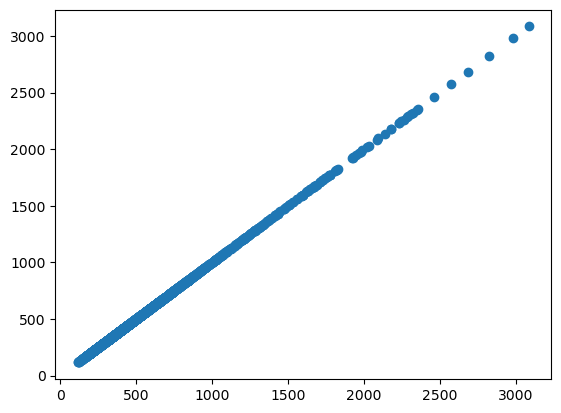

In [16]:
plt.scatter(total_y_pred, total_shap)

### SHAP results

Below is a shap summary plot:
- The x-axis is the SHAP value. Remember, SHAP values are in the same unit of your y variable. Here we have 1 unit of SHAP value interpretated as 1k dollars.
- The y axis is a ranking of the most importance to the least important vairables from top to bottom. The importance is measured by the average absolute SHAP value. Here UTM_Y (the UTM Y coordinate of the property location) is the most important variable. 
- The color of the dots are the features values with high value in red and low value in blue.
- From the color we can observe some general relationships, here I just list two examples:
    - Grade: As grade increases (blue to red), SHAP value increases (left to right), indicating grade and grade's SHAP value have a positive relationship, i.e. higher-grade property will have higher property price.
    - Waterfront: since this is a binary variable, blue will be 0 (w/o waterfront) and red will be 1 (w waterfront) so property with waterfont (red dots) show they increase property price by ~200k dollars.
    - You can extrapolate these observations for other features.

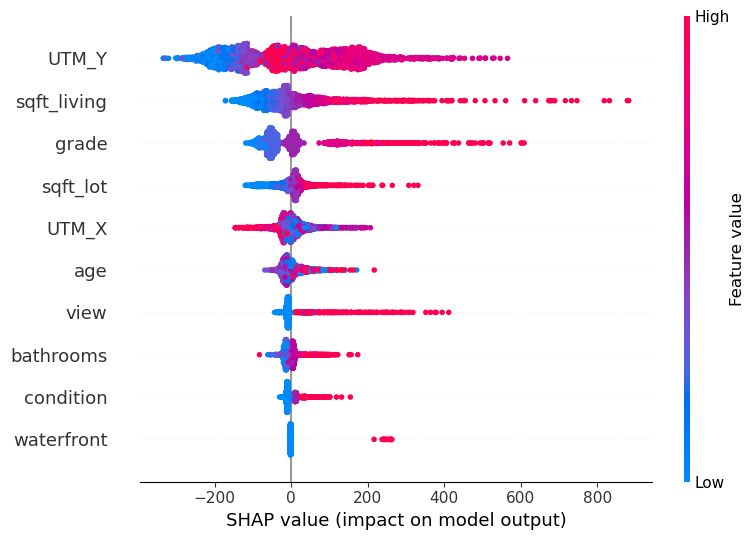

In [17]:
shap.summary_plot(shap_values, X)

Due to the local nature of SHAP values, we can observe how housing attributes determine the price for each individual house. The notation f(x) represents the model's predicted value for a house, while E(f(x)) denotes the average predicted house value. 


A feature colored red indicates a positive contribution, and one colored blue signifies a negative contribution to the difference between the predicted house price and the average predicted house price for the entire Seattle area. These SHAP values explain why the price of a certain house is higher, lower, or similar to the average house price.

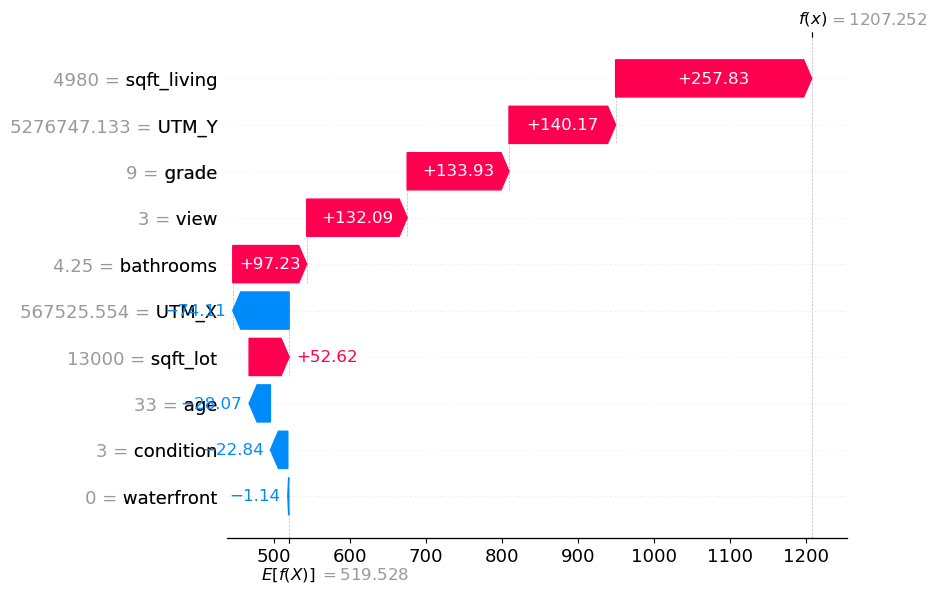

In [18]:
shap.plots.waterfall(shap_values[0])

We can examine another house

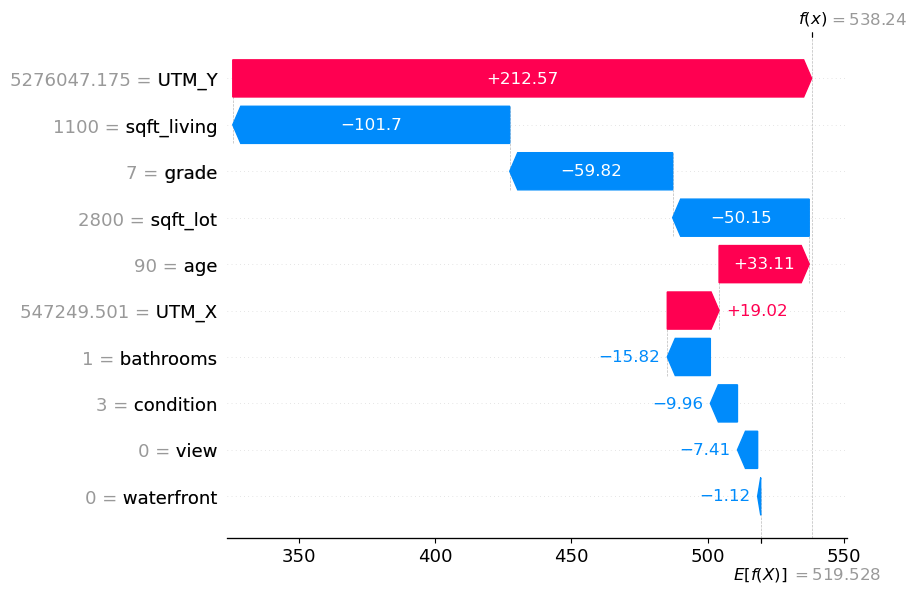

In [19]:
shap.plots.waterfall(shap_values[3])

Next we can plot partial dependence plots which each shows the relatipnship between the feature and its impact/contribution to the house price. We can observe, the shape (lienarity/non-lienarity), magitude (value on the y-axis) and trend (positive/negative) of relationships from these plots.

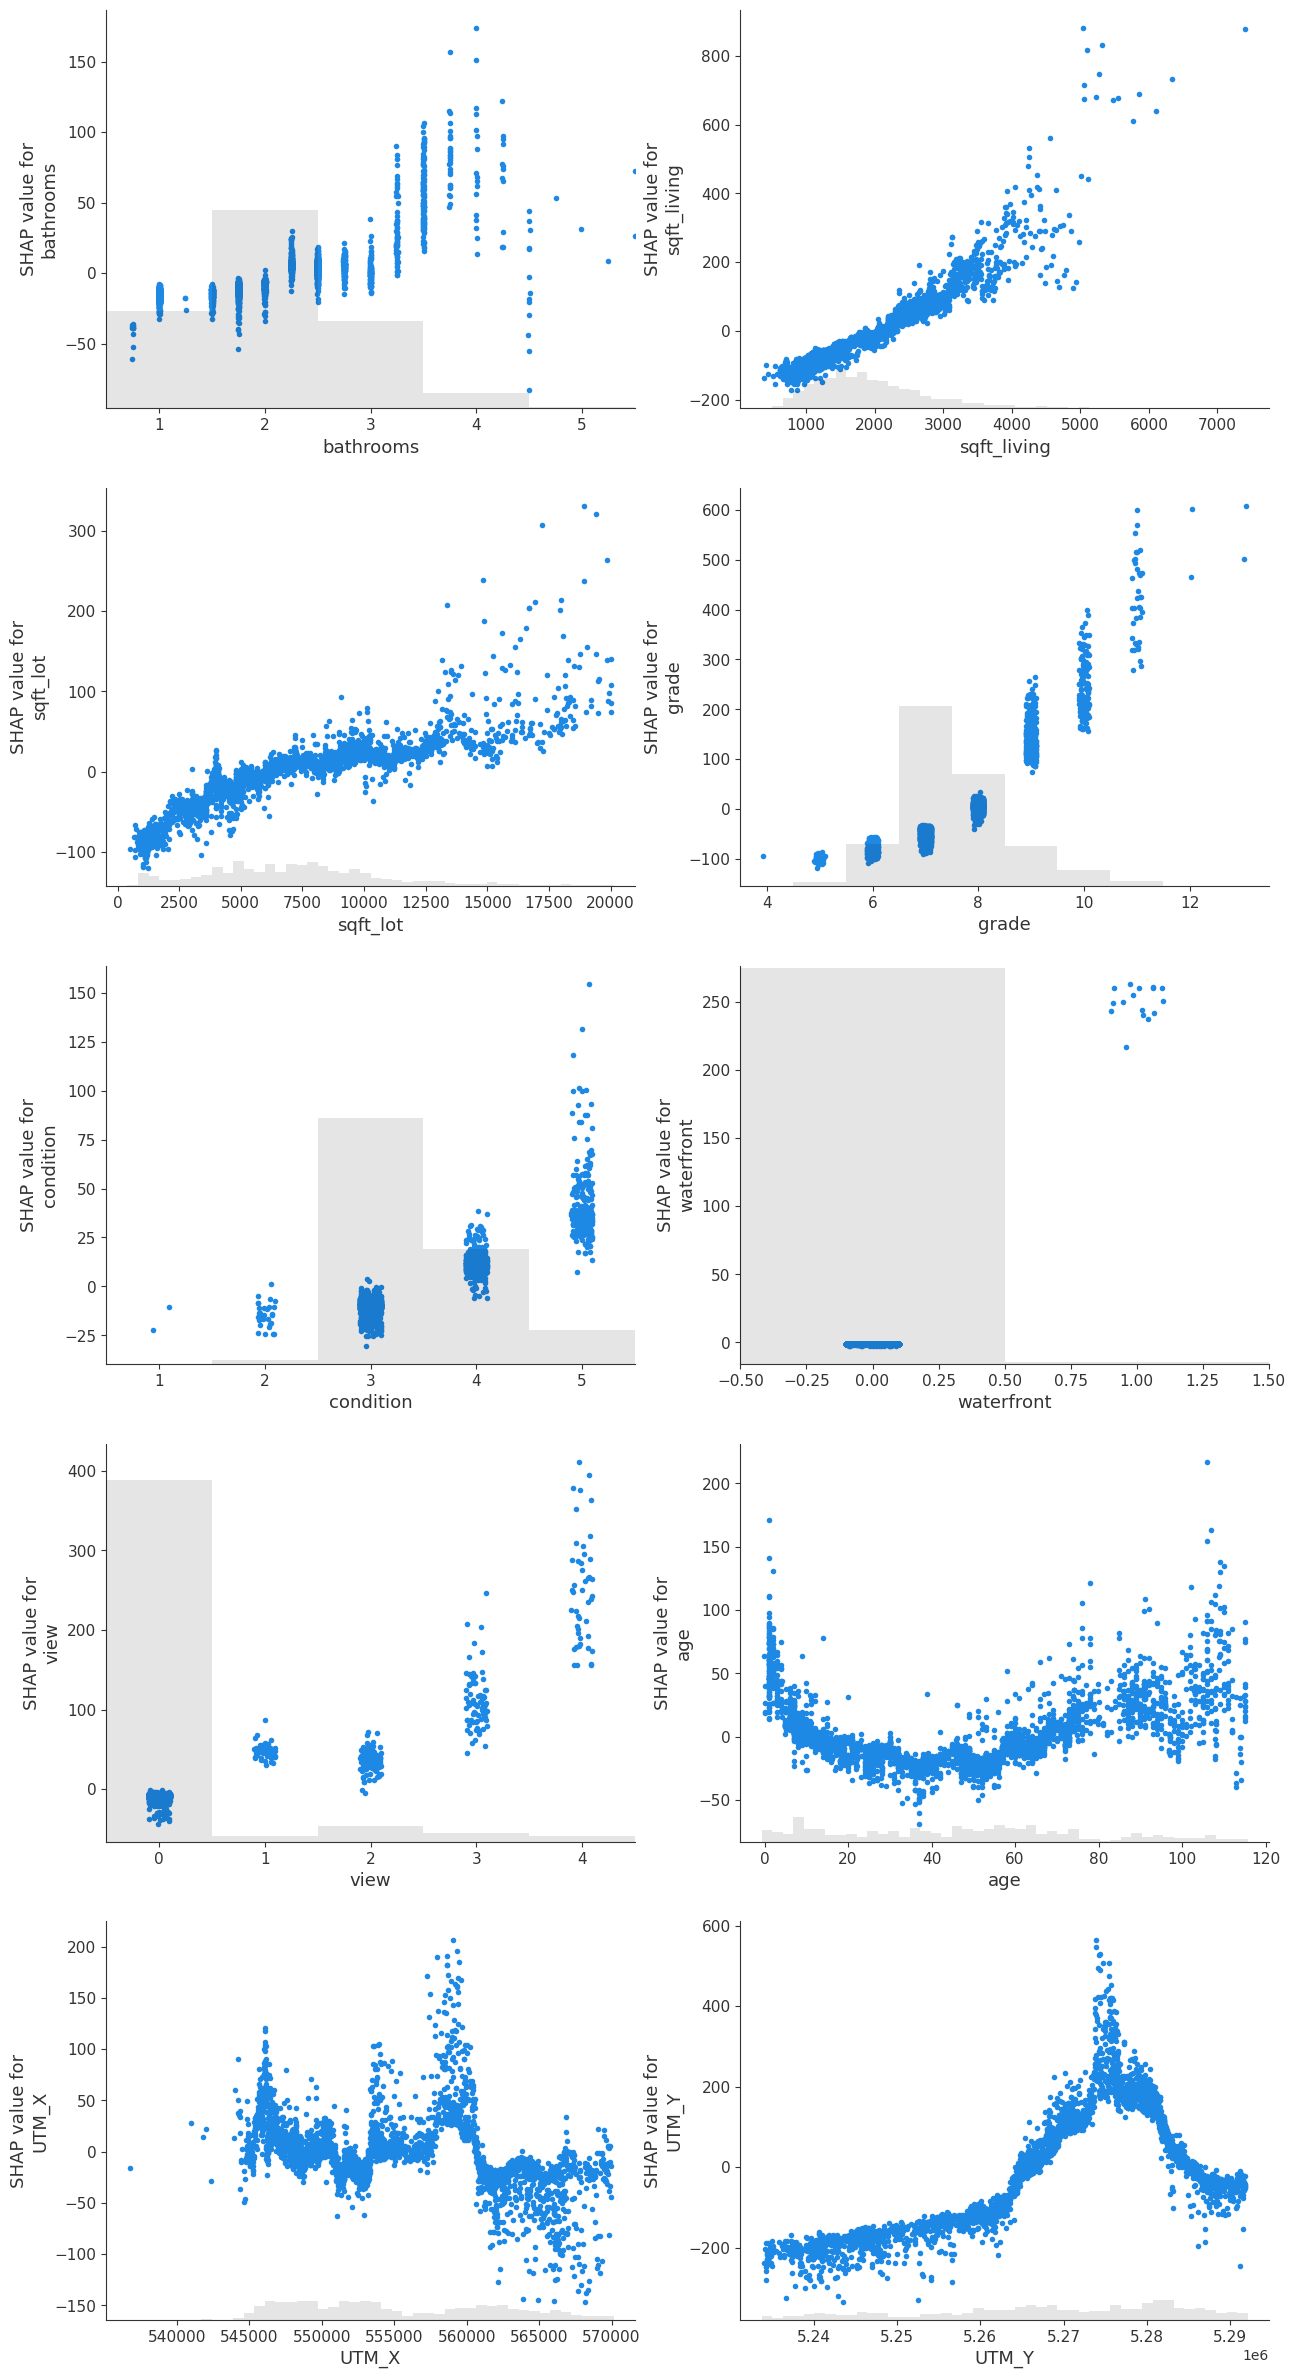

In [20]:
n_rows = 5
n_cols = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 30))  # Create a grid of subplots

for i, ax in enumerate(axs.flat):
    shap.plots.scatter(shap_values[:,i],ax=ax,show=False)

Lastly, we can make a map of the combined contribution from both UTM_X and UTM_Y, which measures how location/context (neighborhood, amenity, preference etc.) affects the house price prediction.

In [21]:
import geopandas as gpd
import contextily as cx

sea_map = gpd.GeoDataFrame(
    X, crs="EPSG:32610", geometry=gpd.points_from_xy(x=X.UTM_X, y=X.UTM_Y))
#sea_map = sea_map.to_crs("EPSG:4326")

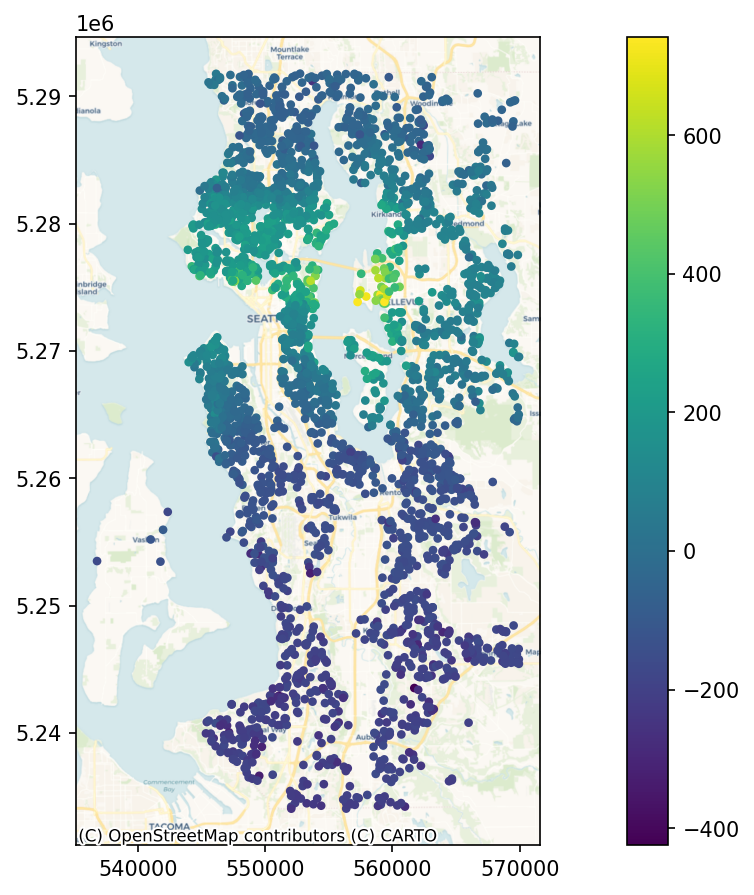

In [22]:
fig, ax = plt.subplots(1, 1,figsize=(15,7),dpi=150)

sea_map.plot(ax=ax, column=shap_values[:,-1].values + shap_values[:,-2].values,legend=True,s=10)


cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Voyager, crs=sea_map.crs,zoom=11)

Northern Seattle neighborhoods and Bellevue are more desired locations.